# Combinatorial Optimization with Physics-Inspired Graph Neural Networks

In this notebook we show how to solve combinatorial optimization problems with physics-inspired graph neural networks, as outlined in M. J. A. Schuetz, J. K. Brubaker, H. G. Katzgraber, _Combinatorial Optimization with Physics-Inspired Graph Neural Networks_, [arXiv:2107.01188](https://arxiv.org/abs/2107.01188). 
Here we focus on the canonical maximum independent set (MIS) problem, but our approach can easily be extended to other combinatorial optimization problems. 
For the actual implementation of the graph neural network we use the open-source ```dgl``` library. 

Please note we have provided a `requirements.txt` file, which defines the environment required to run this code. Because some of the packages are not available on default OSX conda channels, we have also provided suggested channels to find them on. These can be distilled into a single line as such:

> conda create -n \<environment_name\> python=3 --file requirements.txt -c conda-forge -c dglteam -c pytorch

In [1]:
import dgl
import torch
import random
import os
import numpy as np
import pandas as pd
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict, defaultdict
from dgl.nn.pytorch import GraphConv
from itertools import chain, islice, combinations, product
from networkx.algorithms.approximation import maximum_independent_set as mis
from time import time
from tqdm import tqdm

# MacOS can have issues with MKL. For more details, see
# https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


# Step 0 - Define utility functions

We first load a few general utility functions from ```utils.py``` before defining some helper functions specific to the MIS problem. 

### General utilities

In [3]:
from utils import generate_graph, get_gnn, run_gnn_training, qubo_dict_to_torch, gen_combinations, loss_func

### Problem-specific (MIS) utilities

In [4]:
# helper function to generate Q matrix for Maximum Independent Set problem (MIS)
def gen_q_dict_mis(nx_G, penalty=2):
    """
    Helper function to generate QUBO matrix for MIS as minimization problem.
    
    Input:
        nx_G: graph as networkx graph object (assumed to be unweigthed)
    Output:
        Q_dic: QUBO as defaultdict
    """

    # Initialize our Q matrix
    Q_dic = defaultdict(int)

    # Update Q matrix for every edge in the graph
    # all off-diagonal terms get penalty
    for (u, v) in nx_G.edges:
        Q_dic[(u, v)] = penalty

    # all diagonal terms get -1
    for u in nx_G.nodes:
        Q_dic[(u, u)] = -1

    return Q_dic


# Run classical MIS solver (provided by NetworkX)
def run_mis_solver(nx_graph):
    """
    helper function to run traditional solver for MIS.
    
    Input:
        nx_graph: networkx Graph object
    Output:
        ind_set_bitstring_nx: bitstring solution as list
        ind_set_nx_size: size of independent set (int)
        number_violations: number of violations of ind.set condition
    """
    # compare with traditional solver
    t_start = time()
    ind_set_nx = mis(nx_graph)
    t_solve = time() - t_start
    ind_set_nx_size = len(ind_set_nx)

    # get bitstring list
    nx_bitstring = [1 if (node in ind_set_nx) else 0 for node in sorted(list(nx_graph.nodes))]
    edge_set = set(list(nx_graph.edges))

    # Updated to be able to handle larger scale
    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set_nx, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return nx_bitstring, ind_set_nx_size, number_violations, t_solve


# Calculate results given bitstring and graph definition, includes check for violations
def postprocess_gnn_mis(best_bitstring, nx_graph):
    """
    helper function to postprocess MIS results

    Input:
        best_bitstring: bitstring as torch tensor
    Output:
        size_mis: Size of MIS (int)
        ind_set: MIS (list of integers)
        number_violations: number of violations of ind.set condition
    """

    # get bitstring as list
    bitstring_list = list(best_bitstring)

    # compute cost
    size_mis = sum(bitstring_list)

    # get independent set
    ind_set = set([node for node, entry in enumerate(bitstring_list) if entry == 1])
    edge_set = set(list(nx_graph.edges))

    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return size_mis, ind_set, number_violations

# Step 2 - Set hyperparameters

# Step 1 - Build correlation matrix

In [5]:
sp500_hist = pd.read_csv(
    "sp500_hist_prices.csv",
    parse_dates=['Date'],
    index_col='Date'
)

# drop columns with more than 60% NaN values
sp500_hist.dropna(axis=1, thresh=int(len(sp500_hist)*0.4), inplace=True)

# drop columns with negative values in it
sp500_hist.drop(
    columns=sp500_hist.columns[(sp500_hist < 0).any()].values, 
    axis=1,
    inplace=True)

# reduce dataset
sp500_hist = sp500_hist

print(f'Shape: {sp500_hist.shape}')
sp500_hist.head()

Shape: (4279, 484)


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,20.439508,35.305668,38.559849,2.272182,NaN,16.348289,12.590348,6.120000,21.528095,38.520000,...,29.771492,9.832613,32.591091,24.051765,NaN,12.118679,60.463249,42.830002,58.061222,NaN
2006-01-04,20.494427,36.955471,38.834522,2.278869,NaN,16.239967,12.609449,6.151111,21.645647,38.419998,...,29.716309,9.880271,32.646824,24.274343,NaN,12.222367,61.037167,42.410000,58.471172,NaN
2006-01-05,21.031340,37.436260,39.020573,2.260936,NaN,16.038809,12.771802,6.061111,21.807291,38.070000,...,29.539726,9.874971,32.485168,23.998352,NaN,12.743404,60.392624,42.529999,59.002590,NaN
2006-01-06,21.141167,36.766926,38.976273,2.319297,NaN,15.860854,13.016929,6.173333,22.887375,39.000000,...,29.821157,9.912039,33.126179,24.372272,NaN,12.707114,60.083572,44.119999,59.617485,NaN
2006-01-09,21.080151,36.399242,39.481319,2.311697,NaN,15.860854,13.500801,6.116667,22.821247,38.380001,...,31.228340,9.885561,33.109463,24.612658,NaN,12.805617,62.211487,44.790001,59.124062,NaN


In [6]:
METHOD = 'pct'

if METHOD == 'standard':
    df_corr = sp500_hist.corr(method='pearson').abs()
elif METHOD == 'pct':
    sp500_pct = sp500_hist.pct_change()
    sp500_pct = sp500_pct.groupby(sp500_pct.index.year).sum()
    df_corr = sp500_pct.corr(method='pearson').abs()
else:
    raise KeyError("METHOD must be either 'standard' or 'pct'")

df_corr

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.060148,0.157241,0.768849,0.296156,0.650578,0.280147,0.065514,0.525189,0.790364,...,0.663047,0.471917,0.115992,0.529148,0.344200,0.557185,0.697162,0.603583,0.371461,0.250599
AAL,0.060148,1.000000,0.224094,0.215877,0.164439,0.274348,0.071334,0.097154,0.294366,0.025244,...,0.136421,0.057326,0.076684,0.035960,0.131628,0.089025,0.251139,0.095523,0.689320,0.051941
AAP,0.157241,0.224094,1.000000,0.165893,0.082694,0.154293,0.043957,0.207145,0.259158,0.164824,...,0.131879,0.061767,0.195827,0.045652,0.028089,0.217367,0.085204,0.624863,0.294638,0.308580
AAPL,0.768849,0.215877,0.165893,1.000000,0.003183,0.427384,0.358726,0.077663,0.506498,0.652120,...,0.574399,0.493280,0.225341,0.760153,0.207377,0.590832,0.523787,0.606444,0.032689,0.338361
ABBV,0.296156,0.164439,0.082694,0.003183,1.000000,0.438390,0.375691,0.005438,0.133962,0.328067,...,0.171925,0.139648,0.085694,0.013000,0.737339,0.013464,0.284705,0.219766,0.231086,0.287347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.557185,0.089025,0.217367,0.590832,0.013464,0.143048,0.306183,0.011620,0.482253,0.336445,...,0.609360,0.244276,0.057292,0.453082,0.186298,1.000000,0.051380,0.438750,0.356881,0.203073
ZBH,0.697162,0.251139,0.085204,0.523787,0.284705,0.569873,0.224853,0.292309,0.355824,0.682151,...,0.624609,0.645481,0.126241,0.508549,0.354637,0.051380,1.000000,0.356322,0.205201,0.126459
ZBRA,0.603583,0.095523,0.624863,0.606444,0.219766,0.221410,0.511447,0.230220,0.685547,0.754664,...,0.187514,0.382681,0.501544,0.435461,0.520876,0.438750,0.356322,1.000000,0.397458,0.798334
ZION,0.371461,0.689320,0.294638,0.032689,0.231086,0.245172,0.112833,0.364542,0.521887,0.176920,...,0.348359,0.152980,0.070638,0.138350,0.411440,0.356881,0.205201,0.397458,1.000000,0.294993


In [7]:
df_corr.describe()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
count,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,...,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000
mean,0.506297,0.223431,0.210457,0.446698,0.227388,0.381237,0.267273,0.199907,0.448440,0.454357,...,0.395910,0.339142,0.228000,0.429103,0.310935,0.336834,0.427163,0.426707,0.323515,0.314372
std,0.236545,0.172122,0.141183,0.226584,0.153475,0.183304,0.169582,0.161656,0.213368,0.223387,...,0.202376,0.179704,0.173747,0.200260,0.191752,0.181676,0.209262,0.200708,0.182889,0.202766
min,0.002699,0.000118,0.000088,0.003183,0.001336,0.005008,0.000293,0.000129,0.001045,0.003342,...,0.000290,0.000016,0.000259,0.001705,0.000269,0.000073,0.006582,0.002556,0.001881,0.000978
25%,0.302443,0.090328,0.099535,0.269340,0.107051,0.248484,0.129812,0.073419,0.276665,0.285438,...,0.227385,0.211902,0.087841,0.291272,0.154237,0.197280,0.273821,0.284115,0.186960,0.150149
50%,0.535351,0.181212,0.201765,0.435520,0.208785,0.394875,0.242091,0.164115,0.473584,0.485860,...,0.402103,0.357807,0.196977,0.449676,0.289118,0.325834,0.449232,0.452322,0.318251,0.293004
75%,0.703073,0.336138,0.296703,0.636013,0.331365,0.518713,0.381456,0.286818,0.618283,0.639060,...,0.555242,0.469281,0.327914,0.590836,0.453651,0.470022,0.597282,0.577199,0.442642,0.448560
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df_corr.quantile(0.5).mean()

0.3612086905103364

In [9]:
df_corr.where(df_corr >= 0.5).count().sum(), df_corr.where(df_corr < 0.5).count().sum()

(65004, 169252)

# Step 3 - Generate Graph

In [10]:
def build_nx_graph(df_corr:pd.DataFrame, threshold:float) -> nx.Graph:
    """ Returns a Networkx.Graph from a correlation matrix.
        Args:
            df_corr (pd.DataFrame): Correlation matrix
            threshold (float): edges with an correlation coefficient smaller
                than the treshold will be removed. 
                Note: The treshold bust be choosen reasonalbe, the graph must
                not be disconnected.
        Returns:
            nx.Graph
    """
    cor_matrix = df_corr.values.astype('float')
    sim_matrix = 1 - cor_matrix
    G = nx.from_numpy_array(sim_matrix)

    stock_names = df_corr.index.values
    # G = nx.relabel_nodes(G, lambda x: stock_names[x])
    # G.edges(data=True)
    H = G.copy()

    for (u, v, wt) in G.edges.data('weight'):

        if wt >= 1 - threshold:
            H.remove_edge(u, v)

        if u == v:
            H.remove_edge(u, v)

    return H

In [11]:
nx_graph = build_nx_graph(
    df_corr=df_corr,
    threshold=0.5
)

assert nx.is_connected(nx_graph), 'Graph is not connected. Try to lower the threshold'

In [12]:
assert (df_corr.where(df_corr >= 0.5).count().sum() - len(df_corr)) / 2 == len(nx_graph.edges)

In [13]:
# Constructs a random d-regular or p-probabilistic graph
# nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

gen_q_dict_mis(nx_graph)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(
    nx_graph, 
    gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

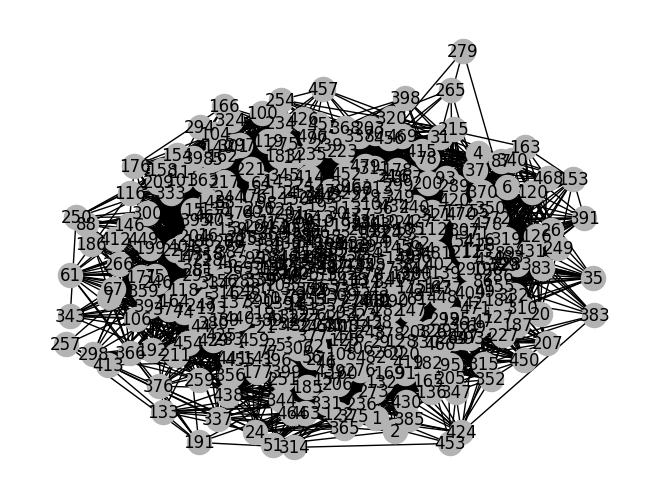

In [14]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

# Step 3 - Set up optimizer/GNN architecture

In [15]:
# # Graph hypers
# n = 500
# d = 3
# p = None
# graph_type = 'reg'

# NN learning hypers #
# number_epochs = 50_000 #int(1e5)
# learning_rate = 1e-4
# PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
# tol = 1e-4          # loss must change by more than tol, or trigger
# patience = 100    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
# n = len(nx_graph.nodes)

# Establish dim_embedding and hidden_dim values
# dim_embedding = int(np.sqrt(n))    # e.g. 10
# hidden_dim = int(dim_embedding/2)  # e.g. 5

In [16]:
n = len(nx_graph.nodes)

params = {
    'lr': [1e-3, 1e-4],
    'dim_embedding': [int(np.sqrt(n))],
    'hidden_dim': [int(np.sqrt(n) / 2)],
    'dropout': [0.0, 0.05,0.1],
    'number_classes': [1],
    'prob_threshold': [0.5],
    'number_epochs': [50_000],
    'tolerance': [1e-4],
    'patience': [1000],
    'model': ["GCN_2L_Model", "SAGE_2L_Model", "GCN_1L_Model", "SAGE_1L_Model"]
}

keys, values = zip(*params.items())
params_set = [dict(zip(keys, v)) for v in product(*values)]
len(params_set), params_set[0]

(24,
 {'lr': 0.001,
  'dim_embedding': 22,
  'hidden_dim': 11,
  'dropout': 0.0,
  'number_classes': 1,
  'prob_threshold': 0.5,
  'number_epochs': 50000,
  'tolerance': 0.0001,
  'patience': 1000,
  'model': 'GCN_2L_Model'})

In [17]:
results = defaultdict(list)
for params in tqdm(params_set):
    # print(params)
    
    net, embed, optimizer = get_gnn(
        n_nodes=n, 
        params=params, 
        model_type=params["model"], 
        torch_device=TORCH_DEVICE, 
        torch_dtype=TORCH_DTYPE)

    # For tracking hyperparameters in results object
    # gnn_hypers.update(opt_params)

    # print('Running GNN...')
    gnn_start = time()

    net, epoch, final_bitstring, best_bitstring, best_loss, inputs, loss_hist, epoch_hist = run_gnn_training(
        q_torch=q_torch, 
        dgl_graph=graph_dgl, 
        net=net, 
        embed=embed, 
        optimizer=optimizer, 
        number_epochs=params['number_epochs'],
        tol=params['tolerance'], 
        patience=params['patience'], 
        prob_threshold=params['prob_threshold'])

    gnn_time = time() - gnn_start

    # post-processing
    final_loss = loss_func(final_bitstring.float(), q_torch)
    # final_bitstring_str = ','.join([str(x) for x in final_bitstring])

    # Process bitstring reported by GNN
    size_mis, ind_set, number_violations = postprocess_gnn_mis(best_bitstring, nx_graph)
    # gnn_tot_time = time() - gnn_start

    # print(f'Independence number found by GNN is {size_mis} with {number_violations} violations')
    # print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')


    # Gathering results
    results["params"].append(params)
    results["net"].append(net)
    results["embed"].append(embed)
    results["optimizer"].append(optimizer)
    results["gnn_time"].append(gnn_time)

    results["final_bitstring"].append(final_bitstring)
    results["best_bitstring"].append(best_bitstring)
    results["best_loss"].append(best_loss.item())
    results["final_loss"].append(final_loss.item())
    results["size_mis"].append(size_mis.item())
    results["ind_set"].append(ind_set)
    results["number_violations"].append(number_violations)

    results["loss_hist"].append(loss_hist)
    results["epoch_hist"].append(epoch_hist)
    # results.append(res)



    # break

  0%|          | 0/24 [00:00<?, ?it/s]c:\Users\roman\Documents\20_Git_workspace\VP2\vp2\.venv\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch: 0, Loss: 16191.1787109375
Epoch: 1000, Loss: 6.35438346862793
Epoch: 2000, Loss: 1.3053901195526123
Epoch: 3000, Loss: 0.44895291328430176
Epoch: 4000, Loss: 0.17808319628238678
Epoch: 5000, Loss: 0.06564819812774658


  4%|▍         | 1/24 [00:50<19:31, 50.92s/it]

Stopping early on epoch 5611 (patience: 1000)
GNN training (n=484) took 50.879
GNN final continuous loss: 0.024413183331489563
GNN best continuous loss: 0.0
Calculating violations...
Epoch: 0, Loss: 64035.8984375
Epoch: 1000, Loss: -6.618271827697754
Epoch: 2000, Loss: -9.715539932250977
Epoch: 3000, Loss: -9.878984451293945


  8%|▊         | 2/24 [01:28<15:52, 43.28s/it]

Stopping early on epoch 3804 (patience: 1000)
GNN training (n=484) took 37.897
GNN final continuous loss: -9.92839527130127
GNN best continuous loss: -9.92839527130127
Calculating violations...
Epoch: 0, Loss: 15196.7880859375
Epoch: 1000, Loss: 4.773220062255859
Epoch: 2000, Loss: 0.939338207244873
Epoch: 3000, Loss: 0.34210216999053955
Epoch: 4000, Loss: 0.15358003973960876
Epoch: 5000, Loss: 0.07582676410675049


 12%|█▎        | 3/24 [02:02<13:35, 38.85s/it]

Stopping early on epoch 5154 (patience: 1000)
GNN training (n=484) took 33.537
GNN final continuous loss: 0.06834866106510162
GNN best continuous loss: 0.0
Calculating violations...
Epoch: 0, Loss: 12700.083984375
Epoch: 1000, Loss: -0.059674832969903946
Epoch: 2000, Loss: -0.9042708873748779
Epoch: 3000, Loss: -1.861912488937378
Epoch: 4000, Loss: -2.1178953647613525
Epoch: 5000, Loss: -2.221281051635742


 17%|█▋        | 4/24 [02:40<12:54, 38.71s/it]

Stopping early on epoch 5705 (patience: 1000)
GNN training (n=484) took 38.453
GNN final continuous loss: -2.254270553588867
GNN best continuous loss: -2.254270553588867
Calculating violations...
Epoch: 0, Loss: 14507.4765625
Epoch: 1000, Loss: 5.886051177978516
Epoch: 2000, Loss: 1.3777209520339966
Epoch: 3000, Loss: 0.5164577960968018
Epoch: 4000, Loss: 0.25328779220581055
Epoch: 5000, Loss: 0.10280922800302505
Epoch: 6000, Loss: 0.04433850571513176
Epoch: 7000, Loss: 0.0007061465876176953
Epoch: 8000, Loss: -0.15354084968566895
Epoch: 9000, Loss: -0.20868626236915588
Epoch: 10000, Loss: -0.6282039284706116
Epoch: 11000, Loss: -1.4650629758834839
Epoch: 12000, Loss: -5.890711784362793
Epoch: 13000, Loss: -12.125446319580078
Epoch: 14000, Loss: -15.619305610656738
Epoch: 15000, Loss: -16.91511344909668
Epoch: 16000, Loss: -16.960561752319336
Epoch: 17000, Loss: -16.986034393310547
Epoch: 18000, Loss: -17.95759391784668
Epoch: 19000, Loss: -17.994186401367188
Epoch: 20000, Loss: -17.99

 21%|██        | 5/24 [10:28<1:01:14, 193.41s/it]

GNN training (n=484) took 467.673
GNN final continuous loss: -19.0
GNN best continuous loss: -19.0
Calculating violations...
Epoch: 0, Loss: 23.00872039794922
Epoch: 1000, Loss: -15.917145729064941
Epoch: 2000, Loss: -22.901113510131836
Epoch: 3000, Loss: -22.974966049194336
Epoch: 4000, Loss: -23.99283790588379
Epoch: 5000, Loss: -28.08698272705078
Epoch: 6000, Loss: -30.980573654174805
Epoch: 7000, Loss: -29.995466232299805
Epoch: 8000, Loss: -29.997486114501953
Epoch: 9000, Loss: -29.999582290649414
Epoch: 10000, Loss: -29.999204635620117
Epoch: 11000, Loss: -29.995454788208008
Epoch: 12000, Loss: -29.99996566772461
Epoch: 13000, Loss: -29.99997329711914
Epoch: 14000, Loss: -29.999977111816406
Epoch: 15000, Loss: -29.99983787536621
Epoch: 16000, Loss: -29.999919891357422
Epoch: 17000, Loss: -30.99983024597168
Epoch: 18000, Loss: -30.999998092651367
Epoch: 19000, Loss: -30.99995231628418
Epoch: 20000, Loss: -30.999982833862305
Epoch: 21000, Loss: -30.999988555908203
Epoch: 22000, Los

 25%|██▌       | 6/24 [18:38<1:28:17, 294.31s/it]

GNN training (n=484) took 490.142
GNN final continuous loss: -31.0
GNN best continuous loss: -37.0
Calculating violations...
Epoch: 0, Loss: 13010.4990234375
Epoch: 1000, Loss: 1.5809979438781738
Epoch: 2000, Loss: 0.30452707409858704
Epoch: 3000, Loss: 0.15991203486919403
Epoch: 4000, Loss: 0.07684919238090515
Epoch: 5000, Loss: 0.013234557583928108
Epoch: 6000, Loss: 0.010537248104810715
Epoch: 7000, Loss: 0.009241970255970955
Epoch: 8000, Loss: -0.1769080013036728
Epoch: 9000, Loss: -0.746830403804779
Epoch: 10000, Loss: -5.924540042877197
Epoch: 11000, Loss: -11.965940475463867
Epoch: 12000, Loss: -13.186833381652832
Epoch: 13000, Loss: -13.197159767150879
Epoch: 14000, Loss: -13.998454093933105
Epoch: 15000, Loss: -13.22460651397705
Epoch: 16000, Loss: -11.020453453063965
Epoch: 17000, Loss: -13.999878883361816
Epoch: 18000, Loss: -13.407175064086914
Epoch: 19000, Loss: -13.543058395385742
Epoch: 20000, Loss: -13.357528686523438
Epoch: 21000, Loss: -13.568561553955078
Epoch: 22000

 29%|██▉       | 7/24 [23:38<1:23:55, 296.23s/it]

Stopping early on epoch 47300 (patience: 1000)
GNN training (n=484) took 300.134
GNN final continuous loss: -19.999988555908203
GNN best continuous loss: -20.00019073486328
Calculating violations...
Epoch: 0, Loss: 1092.1739501953125
Epoch: 1000, Loss: 0.0014584807213395834
Epoch: 2000, Loss: -2.341172456741333
Epoch: 3000, Loss: -23.553943634033203
Epoch: 4000, Loss: -26.408252716064453
Epoch: 5000, Loss: -28.9846134185791
Epoch: 6000, Loss: -27.997228622436523
Epoch: 7000, Loss: -30.921920776367188
Epoch: 8000, Loss: -30.999195098876953
Epoch: 9000, Loss: -30.998947143554688
Epoch: 10000, Loss: -30.999441146850586
Epoch: 11000, Loss: -30.99994659423828
Epoch: 12000, Loss: -30.99997901916504
Epoch: 13000, Loss: -31.0
Epoch: 14000, Loss: -30.999956130981445
Epoch: 15000, Loss: -30.999929428100586
Epoch: 16000, Loss: -30.999897003173828
Epoch: 17000, Loss: -30.999982833862305
Epoch: 18000, Loss: -31.0
Epoch: 19000, Loss: -31.0
Epoch: 20000, Loss: -35.44326400756836
Epoch: 21000, Loss: -

 33%|███▎      | 8/24 [29:15<1:22:24, 309.04s/it]

GNN training (n=484) took 336.43
GNN final continuous loss: -36.0
GNN best continuous loss: -36.00000762939453
Calculating violations...
Epoch: 0, Loss: 15338.947265625
Epoch: 1000, Loss: 7.075220584869385
Epoch: 2000, Loss: 1.4292197227478027
Epoch: 3000, Loss: 0.5714223980903625
Epoch: 4000, Loss: 0.19469617307186127
Epoch: 5000, Loss: 0.06697109341621399
Epoch: 6000, Loss: 0.016289886087179184
Epoch: 7000, Loss: -0.08647923171520233
Epoch: 8000, Loss: -0.18937146663665771
Epoch: 9000, Loss: -0.8833293914794922
Epoch: 10000, Loss: -0.9720795154571533
Epoch: 11000, Loss: -4.763467788696289
Epoch: 12000, Loss: -5.937941074371338
Epoch: 13000, Loss: -5.9875664710998535
Epoch: 14000, Loss: -5.991175174713135
Epoch: 15000, Loss: -5.973377227783203
Epoch: 16000, Loss: -6.9678215980529785
Epoch: 17000, Loss: -6.996432304382324
Epoch: 18000, Loss: -6.995433807373047
Epoch: 19000, Loss: -6.9988932609558105
Epoch: 20000, Loss: -6.999755382537842
Epoch: 21000, Loss: -11.845335006713867
Epoch: 2

 38%|███▊      | 9/24 [37:05<1:29:49, 359.32s/it]

GNN training (n=484) took 469.853
GNN final continuous loss: -18.999488830566406
GNN best continuous loss: -18.9998779296875
Calculating violations...
Epoch: 0, Loss: 0.0035059130750596523
Epoch: 1000, Loss: -35.82356262207031
Epoch: 2000, Loss: -36.992835998535156
Epoch: 3000, Loss: -36.99822998046875
Epoch: 4000, Loss: -36.99732971191406
Epoch: 5000, Loss: -36.99834442138672
Epoch: 6000, Loss: -36.999385833740234
Epoch: 7000, Loss: -38.92374038696289
Epoch: 8000, Loss: -36.99987030029297
Epoch: 9000, Loss: -36.99997329711914
Epoch: 10000, Loss: -36.999961853027344
Epoch: 11000, Loss: -38.99798583984375
Epoch: 12000, Loss: -36.99997329711914
Epoch: 13000, Loss: -37.0
Epoch: 14000, Loss: -36.99999237060547
Epoch: 15000, Loss: -36.9999885559082
Epoch: 16000, Loss: -36.99998474121094
Epoch: 17000, Loss: -37.0
Epoch: 18000, Loss: -37.0
Epoch: 19000, Loss: -36.999996185302734
Epoch: 20000, Loss: -36.996952056884766
Epoch: 21000, Loss: -36.99979782104492
Epoch: 22000, Loss: -38.999988555908

 42%|████▏     | 10/24 [44:55<1:31:48, 393.50s/it]

GNN training (n=484) took 469.975
GNN final continuous loss: -37.0
GNN best continuous loss: -40.0
Calculating violations...
Epoch: 0, Loss: 19245.037109375
Epoch: 1000, Loss: 8.141162872314453
Epoch: 2000, Loss: 1.6383227109909058
Epoch: 3000, Loss: 0.6707118153572083
Epoch: 4000, Loss: 0.24234437942504883
Epoch: 5000, Loss: 0.17297610640525818
Epoch: 6000, Loss: -0.07959742099046707
Epoch: 7000, Loss: -0.26961416006088257
Epoch: 8000, Loss: -0.3422481119632721
Epoch: 9000, Loss: -0.833306074142456
Epoch: 10000, Loss: -0.9777951836585999
Epoch: 11000, Loss: -3.5843873023986816
Epoch: 12000, Loss: -3.9906837940216064
Epoch: 13000, Loss: -16.914831161499023
Epoch: 14000, Loss: -17.979999542236328
Epoch: 15000, Loss: -20.980796813964844
Epoch: 16000, Loss: -20.997060775756836
Epoch: 17000, Loss: -20.997163772583008
Epoch: 18000, Loss: -20.32071876525879
Epoch: 19000, Loss: -20.99941062927246
Epoch: 20000, Loss: -20.999845504760742
Epoch: 21000, Loss: -20.50900650024414
Epoch: 22000, Loss

 46%|████▌     | 11/24 [49:55<1:19:04, 364.94s/it]

GNN training (n=484) took 300.165
GNN final continuous loss: -21.0
GNN best continuous loss: -21.44856834411621
Calculating violations...
Epoch: 0, Loss: 48174.37890625
Epoch: 1000, Loss: 4.13130521774292
Epoch: 2000, Loss: 0.48118704557418823
Epoch: 3000, Loss: -1.5247445106506348
Epoch: 4000, Loss: -1.925093173980713
Epoch: 5000, Loss: -2.7683398723602295
Epoch: 6000, Loss: -3.4850919246673584
Epoch: 7000, Loss: -10.838324546813965
Epoch: 8000, Loss: -18.610780715942383
Epoch: 9000, Loss: -18.96563720703125
Epoch: 10000, Loss: -20.805940628051758
Epoch: 11000, Loss: -21.702272415161133
Epoch: 12000, Loss: -23.991575241088867
Epoch: 13000, Loss: -24.98100471496582
Epoch: 14000, Loss: -21.9932918548584
Epoch: 15000, Loss: -24.000316619873047
Epoch: 16000, Loss: -27.97892189025879
Epoch: 17000, Loss: -31.99950408935547
Epoch: 18000, Loss: -31.98504638671875
Epoch: 19000, Loss: -31.99966812133789
Epoch: 20000, Loss: -31.99997901916504
Epoch: 21000, Loss: -31.99997329711914
Epoch: 22000, 

 50%|█████     | 12/24 [55:08<1:09:50, 349.17s/it]

Stopping early on epoch 49385 (patience: 1000)
GNN training (n=484) took 313.042
GNN final continuous loss: -32.0
GNN best continuous loss: -32.00267791748047
Calculating violations...
Epoch: 0, Loss: 17627.900390625
Epoch: 1000, Loss: 3637.724365234375
Epoch: 2000, Loss: 524.432373046875
Epoch: 3000, Loss: 152.73818969726562
Epoch: 4000, Loss: 61.849212646484375
Epoch: 5000, Loss: 29.16129493713379
Epoch: 6000, Loss: 14.870946884155273
Epoch: 7000, Loss: 7.916865825653076
Epoch: 8000, Loss: 4.31913423538208
Epoch: 9000, Loss: 2.387580633163452
Epoch: 10000, Loss: 1.3279629945755005
Epoch: 11000, Loss: 0.7391480803489685
Epoch: 12000, Loss: 0.4094235897064209
Epoch: 13000, Loss: 0.22412258386611938
Epoch: 14000, Loss: 0.1197577565908432


 54%|█████▍    | 13/24 [57:13<51:33, 281.19s/it]  

Stopping early on epoch 14552 (patience: 1000)
GNN training (n=484) took 124.747
GNN final continuous loss: 0.08314979821443558
GNN best continuous loss: 0.0
Calculating violations...
Epoch: 0, Loss: 62189.98046875
Epoch: 1000, Loss: 11.97793197631836
Epoch: 2000, Loss: -1.6635395288467407
Epoch: 3000, Loss: -4.906562328338623
Epoch: 4000, Loss: -7.580598831176758
Epoch: 5000, Loss: -9.963508605957031
Epoch: 6000, Loss: -12.091931343078613
Epoch: 7000, Loss: -14.618063926696777
Epoch: 8000, Loss: -15.381978988647461
Epoch: 9000, Loss: -15.64795970916748
Epoch: 10000, Loss: -15.818259239196777
Epoch: 11000, Loss: -15.891108512878418


 58%|█████▊    | 14/24 [58:59<38:02, 228.25s/it]

Stopping early on epoch 11177 (patience: 1000)
GNN training (n=484) took 105.877
GNN final continuous loss: -15.899749755859375
GNN best continuous loss: -15.899749755859375
Calculating violations...
Epoch: 0, Loss: 12607.2822265625
Epoch: 1000, Loss: 2583.75
Epoch: 2000, Loss: 365.01727294921875
Epoch: 3000, Loss: 101.6840591430664
Epoch: 4000, Loss: 39.17600631713867
Epoch: 5000, Loss: 17.60685157775879
Epoch: 6000, Loss: 8.58359146118164
Epoch: 7000, Loss: 4.374441623687744
Epoch: 8000, Loss: 2.2736270427703857
Epoch: 9000, Loss: 1.1753807067871094
Epoch: 10000, Loss: 0.5746946930885315
Epoch: 11000, Loss: 0.2416074126958847
Epoch: 12000, Loss: 0.060665324330329895
Epoch: 13000, Loss: -0.0400158129632473


 62%|██████▎   | 15/24 [1:00:23<27:44, 184.95s/it]

Stopping early on epoch 13486 (patience: 1000)
GNN training (n=484) took 84.551
GNN final continuous loss: -0.07184002548456192
GNN best continuous loss: -0.07184002548456192
Calculating violations...
Epoch: 0, Loss: 51859.4140625
Epoch: 1000, Loss: 109.0112533569336
Epoch: 2000, Loss: 20.801591873168945
Epoch: 3000, Loss: 7.263070583343506
Epoch: 4000, Loss: 2.8818352222442627
Epoch: 5000, Loss: 0.9610280394554138
Epoch: 6000, Loss: -0.13235242664813995
Epoch: 7000, Loss: -0.9291141033172607
Epoch: 8000, Loss: -1.9197298288345337
Epoch: 9000, Loss: -2.763140916824341
Epoch: 10000, Loss: -4.195037841796875
Epoch: 11000, Loss: -5.275223731994629
Epoch: 12000, Loss: -5.677430152893066
Epoch: 13000, Loss: -5.8496527671813965
Epoch: 14000, Loss: -5.9259233474731445


 67%|██████▋   | 16/24 [1:01:58<21:01, 157.66s/it]

Stopping early on epoch 14129 (patience: 1000)
GNN training (n=484) took 94.249
GNN final continuous loss: -5.932299613952637
GNN best continuous loss: -5.932299613952637
Calculating violations...
Epoch: 0, Loss: 16139.875
Epoch: 1000, Loss: 1797.24853515625
Epoch: 2000, Loss: 253.82797241210938
Epoch: 3000, Loss: 71.96536254882812
Epoch: 4000, Loss: 29.893508911132812
Epoch: 5000, Loss: 14.342668533325195
Epoch: 6000, Loss: 6.8541059494018555
Epoch: 7000, Loss: 3.451317548751831
Epoch: 8000, Loss: 1.8707023859024048
Epoch: 9000, Loss: 0.9900611639022827
Epoch: 10000, Loss: 0.5668090581893921
Epoch: 11000, Loss: 0.28253844380378723
Epoch: 12000, Loss: 0.16324368119239807
Epoch: 13000, Loss: 0.08482959121465683
Epoch: 14000, Loss: 0.03711986914277077
Epoch: 15000, Loss: 0.014798534102737904
Epoch: 16000, Loss: 0.0006392484065145254
Epoch: 17000, Loss: -0.003128961194306612
Epoch: 18000, Loss: -0.014230347238481045
Epoch: 19000, Loss: -0.029473450034856796
Epoch: 20000, Loss: -0.13352163

 71%|███████   | 17/24 [1:09:25<28:32, 244.61s/it]

GNN training (n=484) took 446.777
GNN final continuous loss: -8.984875679016113
GNN best continuous loss: -8.990652084350586
Calculating violations...
Epoch: 0, Loss: 64035.98046875
Epoch: 1000, Loss: 4.050441741943359
Epoch: 2000, Loss: 4.956842422485352
Epoch: 3000, Loss: 0.7411436438560486
Epoch: 4000, Loss: -0.604804515838623
Epoch: 5000, Loss: -0.8385154604911804
Epoch: 6000, Loss: -1.6308627128601074
Epoch: 7000, Loss: -1.8498339653015137
Epoch: 8000, Loss: -2.016718864440918
Epoch: 9000, Loss: -1.8721365928649902
Epoch: 10000, Loss: -1.9576382637023926
Epoch: 11000, Loss: -2.0154783725738525
Epoch: 12000, Loss: -2.876300573348999
Epoch: 13000, Loss: -2.6082146167755127
Epoch: 14000, Loss: -4.515557289123535
Epoch: 15000, Loss: -6.6099019050598145
Epoch: 16000, Loss: -8.569014549255371
Epoch: 17000, Loss: -10.911202430725098
Epoch: 18000, Loss: -14.874865531921387
Epoch: 19000, Loss: -21.664331436157227
Epoch: 20000, Loss: -28.883394241333008
Epoch: 21000, Loss: -32.9123725891113

 75%|███████▌  | 18/24 [1:17:23<31:29, 314.97s/it]

GNN training (n=484) took 478.728
GNN final continuous loss: -36.999969482421875
GNN best continuous loss: -39.92778396606445
Calculating violations...
Epoch: 0, Loss: 18843.4609375
Epoch: 1000, Loss: 4053.498046875
Epoch: 2000, Loss: 436.8887023925781
Epoch: 3000, Loss: 111.1947021484375
Epoch: 4000, Loss: 42.00630569458008
Epoch: 5000, Loss: 18.95488739013672
Epoch: 6000, Loss: 9.739460945129395
Epoch: 7000, Loss: 4.809570789337158
Epoch: 8000, Loss: 2.4630534648895264
Epoch: 9000, Loss: 1.3886682987213135
Epoch: 10000, Loss: 0.6969526410102844
Epoch: 11000, Loss: 0.3533133268356323
Epoch: 12000, Loss: 0.1452445089817047
Epoch: 13000, Loss: -0.12275038659572601
Epoch: 14000, Loss: -0.2628999948501587
Epoch: 15000, Loss: -0.46479204297065735
Epoch: 16000, Loss: -0.9217214584350586
Epoch: 17000, Loss: -1.7243597507476807
Epoch: 18000, Loss: -4.097838878631592
Epoch: 19000, Loss: -4.8341383934021
Epoch: 20000, Loss: -4.915538787841797
Epoch: 21000, Loss: -6.791070938110352
Epoch: 22000,

 79%|███████▉  | 19/24 [1:22:33<26:07, 313.40s/it]

GNN training (n=484) took 309.709
GNN final continuous loss: -23.999940872192383
GNN best continuous loss: -24.000003814697266
Calculating violations...
Epoch: 0, Loss: 26533.8203125
Epoch: 1000, Loss: 144.5856475830078
Epoch: 2000, Loss: 32.34721755981445
Epoch: 3000, Loss: 11.211174011230469
Epoch: 4000, Loss: 4.477415084838867
Epoch: 5000, Loss: 2.263561964035034
Epoch: 6000, Loss: 1.2951325178146362
Epoch: 7000, Loss: 0.6596858501434326
Epoch: 8000, Loss: 0.37375858426094055
Epoch: 9000, Loss: 0.22985465824604034
Epoch: 10000, Loss: 0.0812971219420433
Epoch: 11000, Loss: 0.12996020913124084
Epoch: 12000, Loss: 0.03310137614607811
Epoch: 13000, Loss: 0.016391003504395485
Epoch: 14000, Loss: -0.10131730139255524
Epoch: 15000, Loss: -0.8958252668380737
Epoch: 16000, Loss: -1.4222919940948486
Epoch: 17000, Loss: -4.590449810028076
Epoch: 18000, Loss: -6.84494686126709
Epoch: 19000, Loss: -17.02175521850586
Epoch: 20000, Loss: -19.283702850341797
Epoch: 21000, Loss: -19.904342651367188


 83%|████████▎ | 20/24 [1:28:05<21:15, 318.96s/it]

GNN training (n=484) took 331.87
GNN final continuous loss: -28.999984741210938
GNN best continuous loss: -29.09665298461914
Calculating violations...
Epoch: 0, Loss: 16473.8125
Epoch: 1000, Loss: 3921.021240234375
Epoch: 2000, Loss: 533.4782104492188
Epoch: 3000, Loss: 153.29824829101562
Epoch: 4000, Loss: 62.49907302856445
Epoch: 5000, Loss: 29.71568489074707
Epoch: 6000, Loss: 15.532232284545898
Epoch: 7000, Loss: 7.803004741668701
Epoch: 8000, Loss: 4.492664813995361
Epoch: 9000, Loss: 2.4189727306365967
Epoch: 10000, Loss: 1.5584725141525269
Epoch: 11000, Loss: 0.7308902144432068
Epoch: 12000, Loss: 0.405082106590271
Epoch: 13000, Loss: 0.22934889793395996
Epoch: 14000, Loss: 0.1574723720550537
Epoch: 15000, Loss: 0.07607357949018478
Epoch: 16000, Loss: 0.04580223187804222
Epoch: 17000, Loss: 0.013928045518696308
Epoch: 18000, Loss: 0.007379135582596064
Epoch: 19000, Loss: -0.002461445750668645
Epoch: 20000, Loss: -0.012741107493638992
Epoch: 21000, Loss: -0.012594718486070633
Epo

 88%|████████▊ | 21/24 [1:36:31<18:45, 375.01s/it]

GNN training (n=484) took 505.643
GNN final continuous loss: -11.991848945617676
GNN best continuous loss: -11.99655818939209
Calculating violations...
Epoch: 0, Loss: 13473.9033203125
Epoch: 1000, Loss: 4.706795692443848
Epoch: 2000, Loss: 43.01004409790039
Epoch: 3000, Loss: 0.43543654680252075
Epoch: 4000, Loss: -0.8216981291770935
Epoch: 5000, Loss: -0.07088609039783478
Epoch: 6000, Loss: -0.10775693506002426
Epoch: 7000, Loss: -0.012277590110898018
Epoch: 8000, Loss: -0.04017059877514839
Epoch: 9000, Loss: -0.882580041885376
Epoch: 10000, Loss: -0.22817444801330566
Epoch: 11000, Loss: -1.052715539932251
Epoch: 12000, Loss: -1.239408254623413
Epoch: 13000, Loss: -1.3187432289123535
Epoch: 14000, Loss: -3.759840488433838
Epoch: 15000, Loss: -6.656100273132324
Epoch: 16000, Loss: -7.017874240875244
Epoch: 17000, Loss: -7.248372554779053
Epoch: 18000, Loss: -8.165672302246094
Epoch: 19000, Loss: -13.804644584655762
Epoch: 20000, Loss: -24.77920913696289
Epoch: 21000, Loss: -28.4747428

 92%|█████████▏| 22/24 [1:45:01<13:51, 415.59s/it]

GNN training (n=484) took 510.18
GNN final continuous loss: -35.977935791015625
GNN best continuous loss: -38.985408782958984
Calculating violations...
Epoch: 0, Loss: 17028.123046875
Epoch: 1000, Loss: 3989.017578125
Epoch: 2000, Loss: 460.72528076171875
Epoch: 3000, Loss: 109.83780670166016
Epoch: 4000, Loss: 43.66923522949219
Epoch: 5000, Loss: 17.848724365234375
Epoch: 6000, Loss: 9.336285591125488
Epoch: 7000, Loss: 5.290557861328125
Epoch: 8000, Loss: 2.5786874294281006
Epoch: 9000, Loss: 1.6020972728729248
Epoch: 10000, Loss: 0.7601206302642822
Epoch: 11000, Loss: 0.34027427434921265
Epoch: 12000, Loss: 0.26827573776245117
Epoch: 13000, Loss: 0.14325375854969025
Epoch: 14000, Loss: 0.02829924412071705
Epoch: 15000, Loss: 0.007696362677961588
Epoch: 16000, Loss: -0.21416202187538147
Epoch: 17000, Loss: -0.4296972155570984
Epoch: 18000, Loss: -0.7542014718055725
Epoch: 19000, Loss: -1.2737144231796265
Epoch: 20000, Loss: -1.718491554260254
Epoch: 21000, Loss: -6.172136306762695
Ep

 96%|█████████▌| 23/24 [1:50:39<06:32, 392.36s/it]

GNN training (n=484) took 338.152
GNN final continuous loss: -28.988554000854492
GNN best continuous loss: -29.001230239868164
Calculating violations...
Epoch: 0, Loss: 56.62814712524414
Epoch: 1000, Loss: 0.07657883316278458
Epoch: 2000, Loss: -0.02191263623535633
Epoch: 3000, Loss: -0.07518817484378815
Epoch: 4000, Loss: -0.8906140923500061
Epoch: 5000, Loss: -1.8313584327697754
Epoch: 6000, Loss: -4.073617935180664
Epoch: 7000, Loss: -4.106827259063721
Epoch: 8000, Loss: -8.399559020996094
Epoch: 9000, Loss: -14.864126205444336
Epoch: 10000, Loss: -18.501441955566406
Epoch: 11000, Loss: -19.724000930786133
Epoch: 12000, Loss: -23.112754821777344
Epoch: 13000, Loss: -23.900299072265625
Epoch: 14000, Loss: -23.30821990966797
Epoch: 15000, Loss: -23.83484649658203
Epoch: 16000, Loss: -23.904977798461914
Epoch: 17000, Loss: -23.99230194091797
Epoch: 18000, Loss: -22.9771728515625
Epoch: 19000, Loss: -23.997779846191406
Epoch: 20000, Loss: -23.99070930480957
Epoch: 21000, Loss: -25.79652

100%|██████████| 24/24 [1:56:31<00:00, 291.31s/it]

GNN training (n=484) took 351.76
GNN final continuous loss: -27.9999942779541
GNN best continuous loss: -28.42768096923828
Calculating violations...


In [45]:
res_df = pd.DataFrame(
    data={
        "gnn_time": results["gnn_time"],
        # "final_bitstring": results['final_bitstring'],
        # "best_bitstring": results['best_bitstring'],
        # "best_bitstring": results['best_bitstring'],
        "best_loss": results['best_loss'],
        "final_loss": results['final_loss'],
        "size_mis": results['size_mis'],
        "ind_set": results['ind_set'],
        "number_violations": results['number_violations'],
        # "lr": results['params']["lr"],
        "params": results['params']
    }
)

df_params = res_df['params'].apply(pd.Series)
res_df = pd.concat([res_df, df_params], axis=1)
res_df = res_df[['gnn_time', 'best_loss', 'final_loss', 'size_mis', 'number_violations', 'lr', 'dim_embedding', 'hidden_dim',
       'dropout', 'number_classes', 'prob_threshold', 'number_epochs',
       'tolerance', 'patience', 'model']]
res_df.sort_values("size_mis", ascending=False)


,gnn_time,best_loss,final_loss,size_mis,number_violations,lr,dim_embedding,hidden_dim,dropout,number_classes,prob_threshold,number_epochs,tolerance,patience,model
17,478.728525,-39.927784,-37.0,40.0,0,0.0001,22,11,0.05,1,0.5,50000,0.0001,1000,SAGE_2L_Model
9,469.975896,-40.000000,-37.0,40.0,0,0.0010,22,11,0.10,1,0.5,50000,0.0001,1000,SAGE_2L_Model
21,510.182251,-38.985409,-36.0,39.0,0,0.0001,22,11,0.10,1,0.5,50000,0.0001,1000,SAGE_2L_Model
5,490.141757,-37.000000,-31.0,37.0,0,0.0010,22,11,0.05,1,0.5,50000,0.0001,1000,SAGE_2L_Model
7,336.430770,-36.000008,-36.0,36.0,0,0.0010,22,11,0.05,1,0.5,50000,0.0001,1000,SAGE_1L_Model
11,313.043490,-32.002678,-32.0,32.0,0,0.0010,22,11,0.10,1,0.5,50000,0.0001,1000,SAGE_1L_Model
23,351.761487,-28.427681,-28.0,29.0,0,0.0001,22,11,0.10,1,0.5,50000,0.0001,1000,SAGE_1L_Model
19,331.871036,-29.096653,-29.0,29.0,0,0.0001,22,11,0.05,1,0.5,50000,0.0001,1000,SAGE_1L_Model
22,338.153450,-29.001230,-29.0,29.0,0,0.0001,22,11,0.10,1,0.5,50000,0.0001,1000,GCN_1L_Model
18,309.709923,-24.000004,-24.0,24.0,0,0.0001,22,11,0.05,1,0.5,50000,0.0001,1000,GCN_1L_Model


In [46]:
res_df.to_csv("./results_hyperPramaOpt.csv", index=False)

In [39]:
# import json
# with open("./results_hyperPramaOpt.json", 'w') as fp:
#     json.dump(results, fp)

# Step 4 - Run GNN training

In [40]:
# print('Running GNN...')
# gnn_start = time()

# _, epoch, final_bitstring, best_bitstring, embed = run_gnn_training(
#     q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
#     gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])

# gnn_time = time() - gnn_start

# Step 5 - Post-process GNN results

In [41]:
# final_loss = loss_func(final_bitstring.float(), q_torch)
# final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# # Process bitstring reported by GNN
# size_mis, ind_set, number_violations = postprocess_gnn_mis(best_bitstring, nx_graph)
# gnn_tot_time = time() - gnn_start

# print(f'Independence number found by GNN is {size_mis} with {number_violations} violations')
# print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

Calculating violations...
Independence number found by GNN is 29 with 0 violations
Took 4048.324s, model training took 351.761s


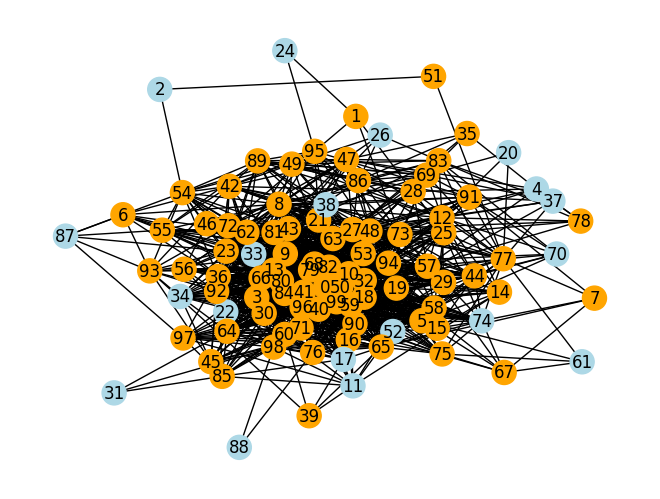

In [ ]:
# # Visualize result
# # Note no light-blue nodes are connected by an edge
# color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
# nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)

# Step 6 - (optional) Compare to classical solver

In [42]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, nx_number_violations, t_solve = run_mis_solver(nx_graph)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {nx_number_violations} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in MIS solver (n=484).
Calculating violations...
Independence number found by nx solver is 35 with 0 violations.
MIS solver took 4.596s


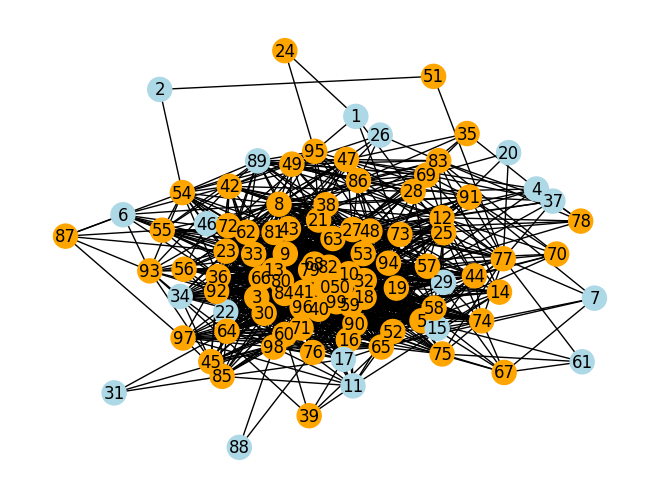

In [ ]:
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)